# Feature selection techniques

As a data scientist or machine learning enthusiast, you know that building an accurate and efficient machine learning model is no small feat. By selecting the most relevant and informative features from your dataset, you can significantly improve the accuracy and efficiency of your model. That's where feature selection comes in. It's one of the several ways to improve your machine learning models, in addition to feature engineering, hyperparameter tuning, regularisation and data preprocessing.


**Feature selection** is the process of selecting the most relevant and informative features from your dataset. As the old saying goes, "garbage in, garbage out" - if your dataset contains irrelevant or noisy features, your model's performance will suffer, no matter how good your algorithm or hyperparameters are.

**This notebook covers:**
1. Filter methods
2. Wrapper methods
3. Embedded methods

These are applied to the breast cancer dataset - however a different dataset can also be used. 

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LassoCV
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# California housing dataset

In [2]:

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
data = pd.read_csv(url)

data = data.dropna()

# Prepare input features and target
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']

# Get the numeric column names
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Normalize the numeric columns using MinMaxScaler
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X = pd.get_dummies(X, drop_first=True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.069060,0.134024,0.099619,1,0,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.083438,0.120868,0.080592,0,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.031980,0.070548,0.316016,0,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.033353,0.092255,0.158915,0,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.019731,0.031409,0.062785,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11397,0.635458,0.125399,0.450980,0.076021,0.077436,0.040192,0.074330,0.339906,0,0,0,0
12081,0.678287,0.129649,0.078431,0.148634,0.160459,0.091230,0.164447,0.296313,0,0,0,0
5447,0.590637,0.156217,0.803922,0.040490,0.057107,0.026598,0.059365,0.179246,0,0,0,0
866,0.230080,0.534538,0.215686,0.145404,0.164960,0.096219,0.173656,0.330202,0,0,1,0


# Fit base model

## Linear Regression

In [9]:
def fit_linear_reg(X_train, y_train, X_test, y_test):
    """
    Fits a linear regression model on the training data and evaluates it on the test data using mean squared error (MSE),
    root mean squared error (RMSE), mean absolute error (MAE), and R-squared (R2).

    Args:
    - X_train (numpy.ndarray): The training data features.
    - y_train (numpy.ndarray): The training data target.
    - X_test (numpy.ndarray): The test data features.
    - y_test (numpy.ndarray): The test data target.

    Returns:
    - None: The function prints the MSE, RMSE, MAE, and R2 values to the console.
    """

    # Instantiate a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    # print('MSE:', round(mse, 2))
    print('RMSE:', round(rmse, 2))
    print('MAE:', round(mae, 2))
    print('R-squared:', round(r2, 3))

    return model

In [10]:
# reg = fit_logistic_reg(X_train, y_train, X_test, y_test)
reg = fit_linear_reg(X_train, y_train, X_test, y_test)

RMSE: 67927.64
MAE: 49643.0
R-squared: 0.654


## Define function to plot feature importances
We will use this in the below techniques

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_importances(df_in, title):
  """make a horizontal bar chart of feature importances"""

  # Plot the feature importances in sorted order
  # Set plot style
  plt.style.use('seaborn-darkgrid')

  # Create horizontal bar plot
  sns.set_style('whitegrid')
  cmap = sns.color_palette('rocket_r', as_cmap=True)
  fig, ax = plt.subplots(figsize=(7, 9))
  sns.barplot(x='Importance', y='Feature', data=df_in, orient='h')
  ax.set_title(title, fontsize=16)
  ax.set_xlabel('Importance Scores', fontsize=12)
  ax.set_ylabel('Features', fontsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.invert_yaxis()
  plt.show()
  

# 1. Filter methods

## Pearson correlation

Pearson correlation feature selection measures the linear relationship between features and the target variable. This technique is useful for identifying important features in regression problems where the target variable is continuous. The correlation coefficient is used to measure the strength and direction of the linear relationship. However, Pearson correlation assumes a linear relationship and may miss non-linear relationships or complex interactions between features.

**Pros:**
- Measures the linear relationship between features and the target variable
- Can identify both positive and negative correlations
- Relatively easy to interpret and explain

**Cons:**
- Assumes a linear relationship between features and the target variable
- May miss non-linear relationships between features and the target variable
- Does not capture complex interactions between features

Selected features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


C:\Users\hjurz\AppData\Local\Temp\ipykernel_9964\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


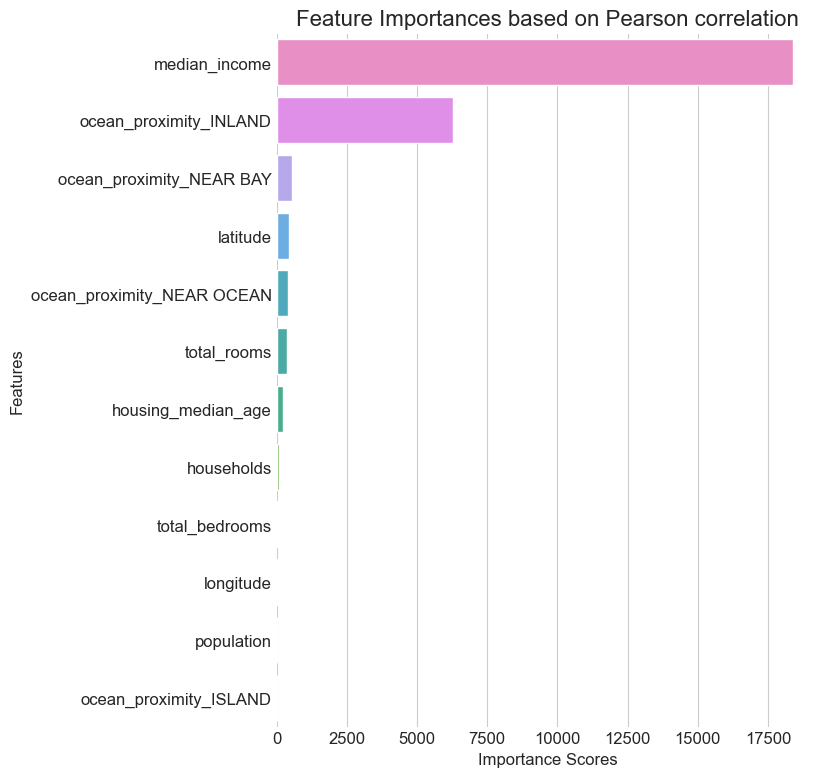

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,households,median_income,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.134024,0.099619,1,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.120868,0.080592,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.070548,0.316016,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.092255,0.158915,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.031409,0.062785,0,0,0


In [17]:
from sklearn.feature_selection import SelectKBest, f_regression

# Apply Pearson correlation feature selection to select the top two features
selector = SelectKBest(f_regression, k=10)
X_filter = selector.fit_transform(X, y)

# Get the indices of the selected features
mask = selector.get_support()

# Make dataframe with new features
X_train_corr = X_train.loc[:,mask]
X_test_corr = X_test.loc[:,mask]
new_features = X_train.loc[:,mask].columns.tolist()

# Get the feature importances and plot
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train.columns, scores)}
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)
print("Selected features:", new_features)
plot_importances(feature_importances, 'Feature Importances based on Pearson correlation')

X_train_corr.head()


## Chi-squared

C:\Users\hjurz\AppData\Local\Temp\ipykernel_9964\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


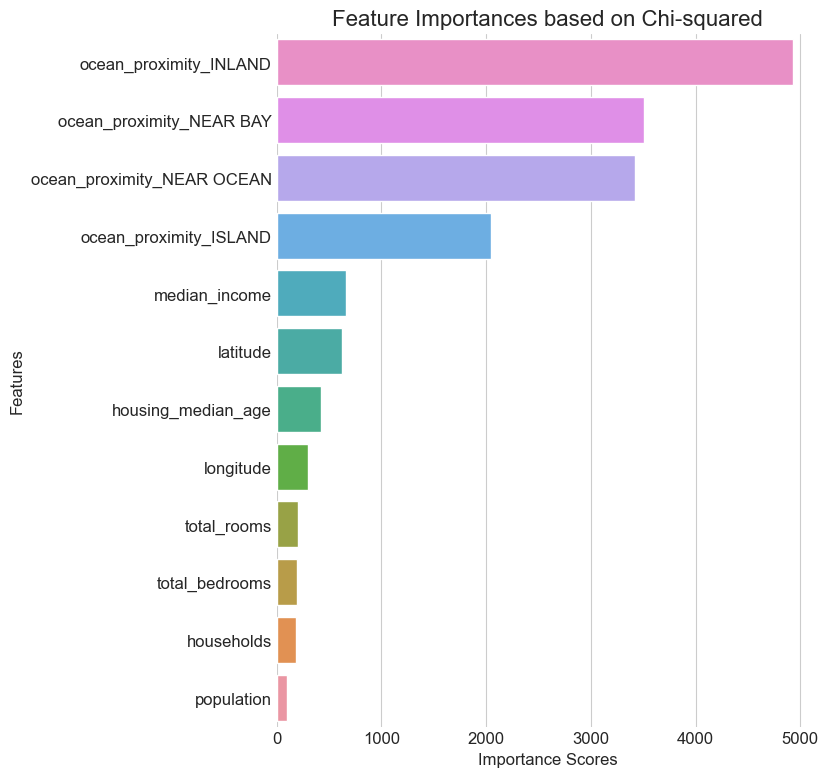

Selected features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.099619,1,0,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.080592,0,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.316016,0,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.158915,0,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.062785,0,0,0,0


In [18]:
from sklearn.feature_selection import SelectKBest, chi2

# Apply chi-squared feature selection to select the top five features
selector = SelectKBest(chi2, k=10)
X_filter = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
mask = selector.get_support()

# Make dataframe with new features
X_train_chi = X_train.loc[:,mask]
X_test_chi = X_test.loc[:,mask]
new_features = X_train.loc[:,mask].columns.tolist()

# Get the feature importances and plot
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train.columns, scores)}
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)
plot_importances(feature_importances, 'Feature Importances based on Chi-squared')

print("Selected features:", new_features)

X_train_chi.head()

## ANOVA

C:\Users\hjurz\AppData\Local\Temp\ipykernel_9964\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


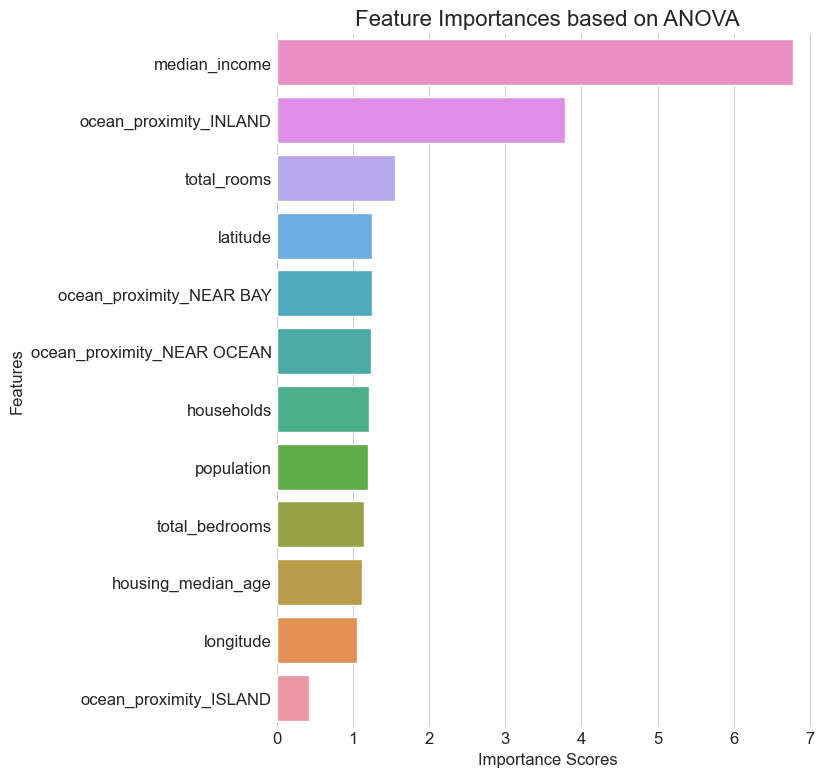

Selected features: ['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.538789,0.431373,0.088891,0.137492,0.069060,0.134024,0.099619,1,0,0
7292,0.153029,0.647059,0.056539,0.116698,0.083438,0.120868,0.080592,0,0,0
17618,0.503719,0.509804,0.072664,0.071850,0.031980,0.070548,0.316016,0,0,0
17518,0.510096,0.666667,0.055623,0.094041,0.033353,0.092255,0.158915,0,0,0
5172,0.149841,0.784314,0.021186,0.032123,0.019731,0.031409,0.062785,0,0,0


In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

# Apply ANOVA F-test feature selection to select the top two features
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
mask = selector.get_support()

# Make dataframe with new features
X_train_anova = X_train.loc[:,mask]
X_test_anova = X_test.loc[:,mask]
new_features = X_train.loc[:,mask].columns.tolist()

# Get the feature importances and plot
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train.columns, scores)}
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)
plot_importances(feature_importances, 'Feature Importances based on ANOVA')

print("Selected features:", new_features)

X_train_anova.head()

### Test linear regression using selscted features

In [20]:
print("\nFeature selection by Pearson Correlation:")
reg = fit_linear_reg(X_train_corr, y_train, X_test_corr, y_test)

print("\nFeature selection by Chi-squared:")
reg = fit_linear_reg(X_train_chi, y_train, X_test_chi, y_test)

print("\nFeature selection by ANOVA:")
reg = fit_linear_reg(X_train_anova, y_train, X_test_anova, y_test)


Feature selection by Pearson Correlation:
RMSE: 70336.72
MAE: 51410.14
R-squared: 0.629

Feature selection by Chi-squared:
RMSE: 70450.73
MAE: 51552.08
R-squared: 0.628

Feature selection by ANOVA:
RMSE: 69229.1
MAE: 50468.57
R-squared: 0.64


In [21]:
# print("\nFeature selection by Pearson Correlation:")
# reg = fit_logistic_reg(X_train_corr, y_train, X_test_corr, y_test)

# print("\nFeature selection by Chi-squared:")
# reg = fit_logistic_reg(X_train_chi, y_train, X_test_chi, y_test)

# print("\nFeature selection by ANOVA:")
# reg = fit_logistic_reg(X_train_anova, y_train, X_test_anova, y_test)

# 2. Wrapper methods

## Recursive feature elimination (RFE)

Selected features:
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND'],
      dtype='object')


C:\Users\hjurz\AppData\Local\Temp\ipykernel_9964\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


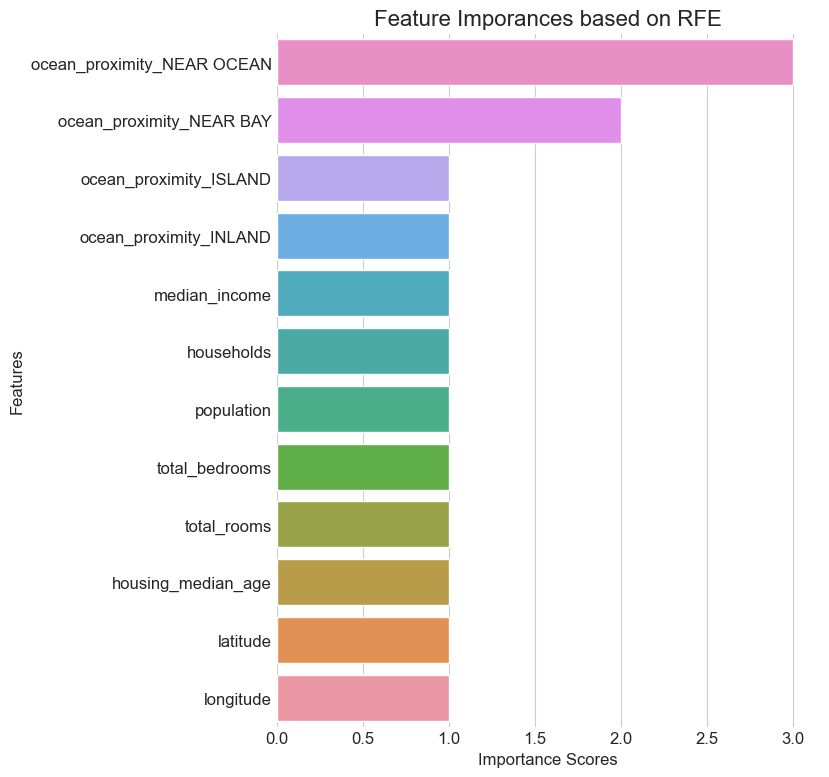

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.069060,0.134024,0.099619,1,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.083438,0.120868,0.080592,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.031980,0.070548,0.316016,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.033353,0.092255,0.158915,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.019731,0.031409,0.062785,0,0
...,...,...,...,...,...,...,...,...,...,...
11397,0.635458,0.125399,0.450980,0.076021,0.077436,0.040192,0.074330,0.339906,0,0
12081,0.678287,0.129649,0.078431,0.148634,0.160459,0.091230,0.164447,0.296313,0,0
5447,0.590637,0.156217,0.803922,0.040490,0.057107,0.026598,0.059365,0.179246,0,0
866,0.230080,0.534538,0.215686,0.145404,0.164960,0.096219,0.173656,0.330202,0,0


In [22]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create a model object 
model = LinearRegression()

# Create a Recursive Feature Elimination object
rfe = RFE(estimator=model, n_features_to_select=10, step=1)

# Fit the RFE object to the data
rfe.fit(X_train, y_train.values.ravel())

# Filter the dataset for the selected features
X_train_rfe = X_train.iloc[:,rfe.support_]
X_test_rfe = X_test.iloc[:,rfe.support_]
selected_features = X_train_rfe.columns

# Print the selected features
print('Selected features:')
print(selected_features)

# Get the feature importances and plot
df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rfe.ranking_})
df_importance = df_importance.sort_values(by='Importance', ascending=True)
plot_importances(df_importance, 'Feature Imporances based on RFE')

# Show the filtered dataset
X_train_rfe

## Sequential feature selection (SFS)

In [23]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create a model object 
model = LinearRegression()

# Create a Sequential Feature Selector object
sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=10, direction='forward')

# Fit the Sequential Feature Selector object to the data
sfs.fit(X_train, y_train.values.ravel())

# Filter the dataset for the selected features
X_train_sfs = X_train.iloc[:,sfs.support_]
X_test_sfs = X_test.iloc[:,sfs.support_]
selected_features = X_train_sfs.columns.tolist()

# Print the selected features
print('Selected features:')
print(selected_features)

# Show the filtered dataset
X_train_sfs

Selected features:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,median_income,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.069060,0.099619,1,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.083438,0.080592,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.031980,0.316016,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.033353,0.158915,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.019731,0.062785,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11397,0.635458,0.125399,0.450980,0.076021,0.077436,0.040192,0.339906,0,0,0
12081,0.678287,0.129649,0.078431,0.148634,0.160459,0.091230,0.296313,0,0,0
5447,0.590637,0.156217,0.803922,0.040490,0.057107,0.026598,0.179246,0,0,0
866,0.230080,0.534538,0.215686,0.145404,0.164960,0.096219,0.330202,0,1,0


In [24]:
print("\nFeature selection by RFE:")
reg = fit_linear_reg(X_train_rfe, y_train, X_test_rfe, y_test)

print("\nFeature selection by SFS:")
reg = fit_linear_reg(X_train_sfs, y_train, X_test_sfs, y_test)


Feature selection by RFE:
RMSE: 67943.85
MAE: 49688.19
R-squared: 0.654

Feature selection by SFS:
RMSE: 68088.61
MAE: 49749.15
R-squared: 0.652


# 3 Embedded methods

In [26]:
def eval_regress(model, X_train, X_test, y_test):
    # Compute predictions on the test set
    y_pred = model.predict(X_test)

    # Compute the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    # print('MSE:', round(mse, 2))
    print('RMSE:', round(rmse, 2))
    print('MAE:', round(mae, 2))
    print('R-squared:', round(r2, 3))

## Ridge Regression

In [27]:
from sklearn.linear_model import RidgeCV

# Create a RidgeCV object
ridge = RidgeCV(cv=5)

# Fit the RidgeCV object to the data
ridge.fit(X_train, y_train.ravel())

# Create a boolean mask of the selected features
mask = ridge.coef_ != 0

# Get the names of the selected features
selected_features = X_train.columns[mask]

# Create a dataframe with the selected features
df_selected = pd.DataFrame(X_train[selected_features], columns=selected_features)

# Print the selected features
print('Selected features:')
print(selected_features.tolist())

# Show the filtered dataframe
df_selected.head()

Selected features:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.069060,0.134024,0.099619,1,0,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.083438,0.120868,0.080592,0,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.031980,0.070548,0.316016,0,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.033353,0.092255,0.158915,0,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.019731,0.031409,0.062785,0,0,0,0


In [28]:
eval_regress(ridge, X_train, X_test, y_test)

RMSE: 67961.09
MAE: 49664.79
R-squared: 0.654


## Lasso regression
Lasso regression, similar to ridge regression, is a regularization technique used to prevent overfitting in linear regression models. Instead of adding a penalty term proportional to the square of the coefficients as in ridge regression, lasso regression adds a penalty term proportional to the absolute value of the coefficients. This has the effect of shrinking some coefficients all the way to zero, effectively removing some features entirely from the model.

Lasso regression is often used for feature selection as a result of this property, as it can be used to identify the most important predictors in a dataset. Like ridge regression, the strength of the penalty term is controlled by the regularization parameter, which is typically chosen through cross-validation. Lasso regression can be particularly useful in situations where there are many predictors but only a few are expected to have a strong effect on the outcome, or where the goal is to identify a parsimonious model that uses as few predictors as possible without sacrificing too much predictive power.

In [29]:
from sklearn.linear_model import LassoCV

# Create a LassoCV object
lasso = LassoCV(cv=5)

# Fit the LassoCV object to the data
lasso.fit(X_train, y_train.ravel())

# Create a boolean mask of the selected features
mask = lasso.coef_ != 0

# Get the names of the selected features
selected_features = X_train.columns[mask]

# Create a dataframe with the selected features
df_selected = pd.DataFrame(X_train[selected_features], columns=selected_features)

# Print the selected features
print('Selected features:')
print(selected_features.tolist())

# Show the filtered dataframe
df_selected.head()

Selected features:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
19566,0.337649,0.538789,0.431373,0.088891,0.137492,0.069060,0.134024,0.099619,1,0,0,0
7292,0.610558,0.153029,0.647059,0.056539,0.116698,0.083438,0.120868,0.080592,0,0,0,0
17618,0.240040,0.503719,0.509804,0.072664,0.071850,0.031980,0.070548,0.316016,0,0,0,0
17518,0.243028,0.510096,0.666667,0.055623,0.094041,0.033353,0.092255,0.158915,0,0,0,0
5172,0.604582,0.149841,0.784314,0.021186,0.032123,0.019731,0.031409,0.062785,0,0,0,0


In [30]:
eval_regress(lasso, X_train, X_test, y_test)

RMSE: 68199.52
MAE: 49837.2
R-squared: 0.651


# Decision Trees

RMSE: 48093.48
MAE: 31957.83
R-squared: 0.826


C:\Users\hjurz\AppData\Local\Temp\ipykernel_9964\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


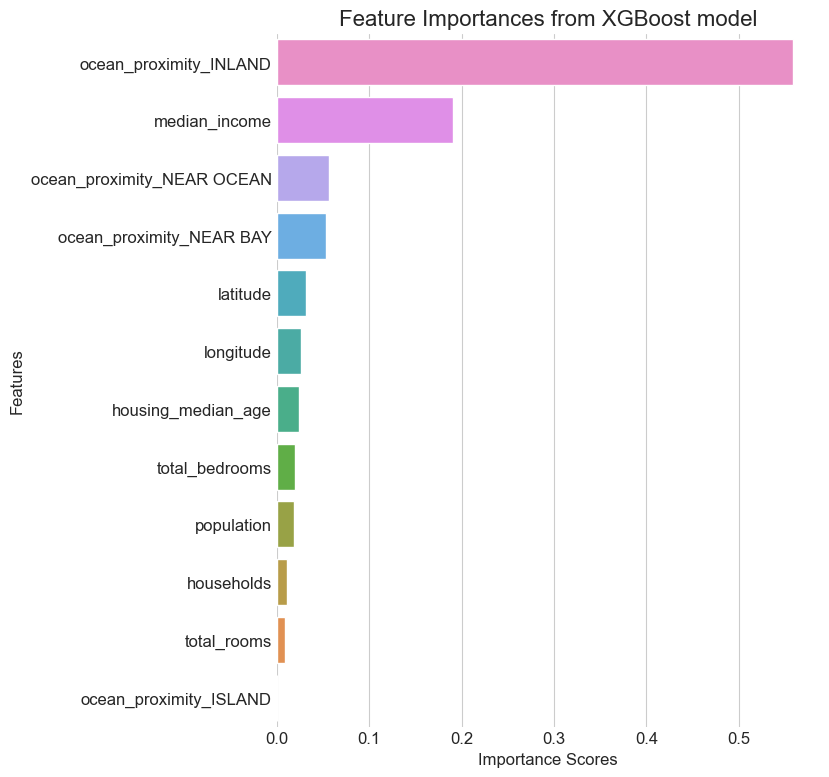

In [34]:
def fit_xgb_reg(X_train, y_train, X_test, y_test):
    """
    Fits an XGBoost model on the training data and evaluates it on the test data using mean squared error (MSE),
    root mean squared error (RMSE), mean absolute error (MAE), and R-squared (R2). It also extracts the feature
    importances.

    Args:
    - X_train (numpy.ndarray): The training data features.
    - y_train (numpy.ndarray): The training data target.
    - X_test (numpy.ndarray): The test data features.
    - y_test (numpy.ndarray): The test data target.

    Returns:
    - None: The function prints the MSE, RMSE, MAE, and R2 values to the console, and plots the feature importances.
    """

    # Instantiate an XGBoost model with default hyperparameters
    xgb_reg = xgb.XGBRegressor()

    # Train the model on the training data
    xgb_reg.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = xgb_reg.predict(X_test)

    # Compute the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    # print('MSE:', round(mse, 2))
    print('RMSE:', round(rmse, 2))
    print('MAE:', round(mae, 2))
    print('R-squared:', round(r2, 3))

    # Extract the feature importances and create a dataframe
    importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_reg.feature_importances_})

    # Sort the features by importance
    importances = importances.sort_values('Importance', ascending=True)

    return xgb_reg, importances

xgb_reg, importances = fit_xgb_reg(X_train, y_train, X_test, y_test)

plot_importances(importances, 'Feature Importances from XGBoost model')

new_importances = importances[0:10]
selected_features = new_importances.Feature.to_list()
new_importances

X_train_xgb = X_train[selected_features]
X_test_xgb = X_test[selected_features]

In [36]:
xgb_reg, importances = fit_xgb_reg(X_train_xgb, y_train, X_test_xgb, y_test)

RMSE: 49992.51
MAE: 33855.81
R-squared: 0.813
